## TARGET AND HISTORY PATH VISUALISATION

In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from collections import Counter
from prettytable import PrettyTable

#l5kit imports  
from l5kit.data import ChunkedDataset, LocalDataManager
from l5kit.dataset import EgoDataset, AgentDataset
from l5kit.rasterization import build_rasterizer
from l5kit.configs import load_config_data
from l5kit.visualization import draw_trajectory, TARGET_POINTS_COLOR
from l5kit.geometry import transform_points
from l5kit.data import PERCEPTION_LABELS
from scipy import stats

In [3]:
# set env variable for data
os.environ["L5KIT_DATA_FOLDER"] = "lyft-motion-prediction-autonomous-vehicles/"
dm = LocalDataManager(None)

In [4]:
cfg = {
    'format_version': 4,
    'model_params': {
        'model_architecture': 'resnet50',
        'history_num_frames': 10,
        'history_step_size': 1,
        'history_delta_time': 0.1,
        'future_num_frames': 50,
        'future_step_size': 1,
        'future_delta_time': 0.1
    },
    
    'raster_params': {
        'raster_size': [224, 224],
        'pixel_size': [0.5, 0.5],
        'ego_center': [0.25, 0.5],
        'map_type': 'py_semantic',
        'semantic_map_key': 'semantic_map/semantic_map.pb',
        'semantic_map_key': 'semantic_map/semantic_map.pb',
        'dataset_meta_key': 'meta.json',
        'filter_agents_threshold': 0.5,
        'disable_traffic_light_faces': False
    },
    
    'test_data_loader': {
        'key': 'scenes/test.zarr',
        'batch_size': 12,
        'shuffle': False,
        'num_workers': 0
    },

    'sample_data_loader': {
        'key': 'scenes/sample.zarr',
        'batch_size': 12,
        'shuffle': False,
        'num_workers': 4
    }
}

## UTILITY FUNCTIONS

In [16]:
def plot_history_pos(ax, data):
    ax.plot(data['history_positions'][:,0], data['history_positions'])

def plot_target_pos(ax, data):
    ax.plot(data['target_positions'][:,0], data['target_positions'][:,1])

In [27]:
def print_Dataset_Info(Dataset):
    print('target_availabilities shape' , Dataset['target_availabilities'].shape)
    print('target position shape' , Dataset['target_positions'].shape)
    print('target yaw shape' , Dataset['target_yaws'].shape)
    print('history_positions shape' , Dataset['history_positions'].shape)
    print('history_yaws shape' , Dataset['history_yaws'].shape)
    print('history_availabilities shape' , Dataset['history_availabilities'].shape)
    print('image shape' , Dataset['image'].shape)    

In [28]:
def plot_Dataset_bev(data):
    temp = data['image'].transpose(1,2,0)
    print('Input shape :', {data['image'].shape}, ' Output shape : ', {temp.shape})
    plt.imshow(temp[:, :, -3:][::-1])

In [40]:
def plot_2d_points(points2D):
    plt.figure(figsize=(12, 8))
    plt.plot(points2D[:,0], points2D[:,1])
    plt.plot(points2D[:,0], points2D[:,1], 'go')
    plt.axis('equal')
    plt.grid(True)

In [34]:
def plot_agent_history(data):
    plt.figure(figsize=(100,100))
    for i in range(cfg['model_params']['history_num_frames'] + 1):
        plt.subplot(cfg['model_params']['history_num_frames'] + 1, 1, i+1)
        plt.imshow(data['image'][i])
    plt.show()

In [35]:
def plot_av_history(data):
    plt.figure(figsize=(100,100))
    for i in range(cfg['model_params']['history_num_frames'] + 1):
        plt.subplot(cfg['model_params']['history_num_frames'] + 1, 1, i+1)
        plt.imshow(data['image'][i + cfg['model_params']['history_num_frames'] + 1])
    plt.show()    

## Sample data reading

In [5]:
%%time
rasterizer = build_rasterizer(cfg, dm)

CPU times: user 4.13 s, sys: 31.6 ms, total: 4.16 s
Wall time: 4.44 s


In [6]:
%%time
sample_zarr = ChunkedDataset(dm.require(cfg["sample_data_loader"]["key"])).open()

CPU times: user 0 ns, sys: 20.4 ms, total: 20.4 ms
Wall time: 54 ms


In [7]:
%%time
sample_AgentDataset = AgentDataset(cfg, sample_zarr, rasterizer)

CPU times: user 37.3 ms, sys: 42.4 ms, total: 79.8 ms
Wall time: 110 ms


In [8]:
print(sample_AgentDataset)

+------------+------------+------------+---------------+-----------------+----------------------+----------------------+----------------------+---------------------+
| Num Scenes | Num Frames | Num Agents | Num TR lights | Total Time (hr) | Avg Frames per Scene | Avg Agents per Frame | Avg Scene Time (sec) | Avg Frame frequency |
+------------+------------+------------+---------------+-----------------+----------------------+----------------------+----------------------+---------------------+
|    100     |   24838    |  1893736   |     316008    |       0.69      |        248.38        |        76.24         |        24.83         |        10.00        |
+------------+------------+------------+---------------+-----------------+----------------------+----------------------+----------------------+---------------------+


In [9]:
print('Agents shape : ', sample_zarr.agents.shape)
print('Frames shape : ', sample_zarr.frames.shape)
print('Scense shape : ', sample_zarr.scenes.shape)

Agents shape :  (1893736,)
Frames shape :  (24838,)
Scense shape :  (100,)


In [10]:
len(sample_AgentDataset)

111634

In [11]:
temp = sample_AgentDataset[20]
temp.keys()

dict_keys(['image', 'target_positions', 'target_yaws', 'target_availabilities', 'history_positions', 'history_yaws', 'history_availabilities', 'world_to_image', 'raster_from_world', 'raster_from_agent', 'agent_from_world', 'world_from_agent', 'track_id', 'timestamp', 'centroid', 'yaw', 'extent'])

In [51]:
temp['extent']

array([1.6454978, 0.6536734, 1.6955528], dtype=float32)

In [12]:
np.random.seed(1004)
SAMPLES_TO_PLOT = 50
sampled_indices = np.random.randint(0, len(sample_AgentDataset), (SAMPLES_TO_PLOT,))

## TARGET POSITIONS IN AGENT FRAME

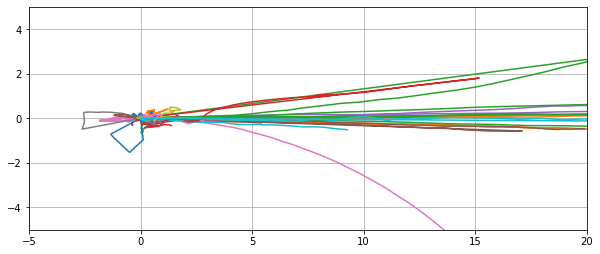

In [36]:
fig, ax = plt.subplots(figsize = (10,10)) #1,1,
ax.grid(True)
ax.set_aspect('equal', 'box')
ax.set_xlim([-5, 20])
ax.set_ylim([-5, 5])

for i in range(SAMPLES_TO_PLOT):
    plot_target_pos(ax, sample_AgentDataset[sampled_indices[i]])

## HISTORY POSITIONS IN AGENT FRAME

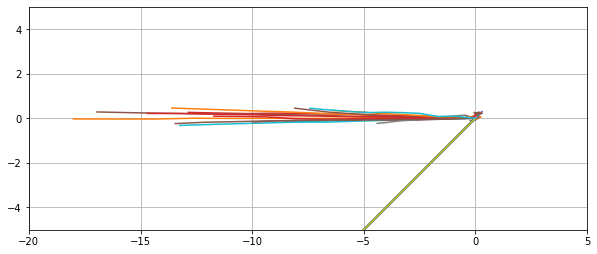

In [37]:
fig, ax = plt.subplots(figsize = (10,10)) #1,1,
ax.grid(True)
ax.set_aspect('equal', 'box')
ax.set_xlim([-20, 5])
ax.set_ylim([-5, 5])

for i in range(SAMPLES_TO_PLOT):
    plot_history_pos(ax, sample_AgentDataset[sampled_indices[i]])

In [38]:
TEST_INDEX = 50
data = sample_AgentDataset[TEST_INDEX]

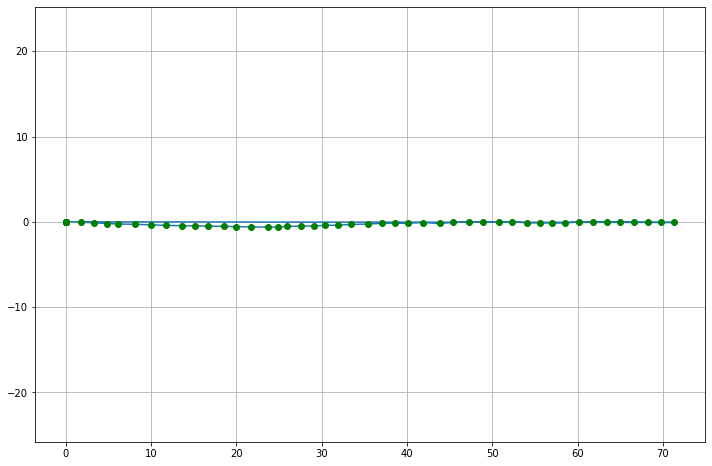

In [41]:
agents_coords = data['target_positions']
plot_2d_points(agents_coords)

## TARGET POSITIONS IN WORLD FRAME

In [42]:
world_from_agents = data["world_from_agent"]
world_from_agents

array([[ 8.49651368e-01,  5.27344814e-01,  9.04762512e+02],
       [-5.27344814e-01,  8.49651368e-01, -1.51283508e+03],
       [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00]])

In [44]:
centroids = data["centroid"]
centroids

array([  904.76251221, -1512.83508301])

In [49]:
t = transform_points(agents_coords, world_from_agents) - centroids[:2]
t.shape

(50, 2)

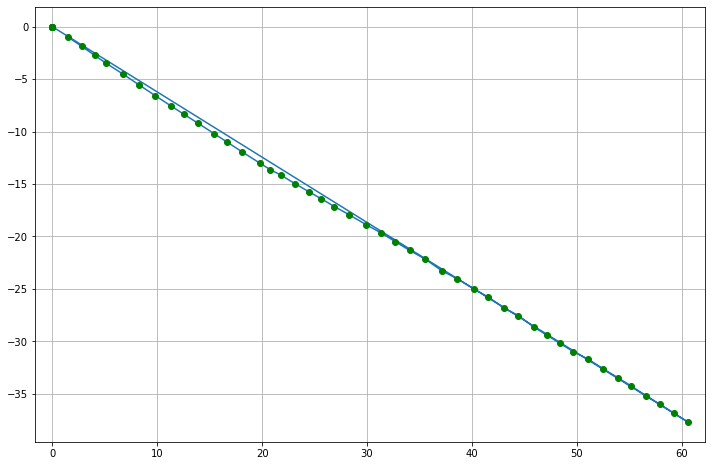

In [50]:
plot_2d_points(t)